In [1]:
import os
import sys
import warnings
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts
from statsmodels.regression.rolling import RollingOLS

# Suppress warnings
warnings.filterwarnings('ignore')

# Graphics setup
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)


# Chapter 3: 평균 회귀 전략 구현 (Implementing Mean Reversion Strategies)
# 분석 리포트

> **생성 시간**: 2026-02-01 17:08:05
> **데이터 출처**: Ernest Chan's "Algorithmic Trading" (2013)

---

## 목차

1. [개요 및 문제 정의](#1-개요-및-문제-정의)
2. [사용 데이터](#2-사용-데이터)
3. [스프레드 유형 비교](#3-스프레드-유형-비교)
4. [볼린저 밴드 전략](#4-볼린저-밴드-전략)
5. [칼만 필터 전략](#5-칼만-필터-전략)
6. [전략 비교 및 결론](#6-전략-비교-및-결론)

---

## 1. 개요 및 문제 정의

### 💡 해결하려는 문제

**"정상성/공적분이 완벽하지 않은 시계열에서 어떻게 실용적인 평균 회귀 전략을 구현할 수 있을까?"**

Chapter 2에서 정상성과 공적분의 이론적 기초를 배웠지만, 실제 시장에서는:

1. **완벽한 정상성/공적분은 드물다** - 단기 또는 계절적 평균 회귀만 존재하는 경우가 많음
2. **헤지 비율이 변한다** - 시간에 따라 두 자산 간 관계가 변화
3. **무한한 자본이 없다** - 선형 전략의 스케일 인은 비현실적

### 📐 핵심 수학적 개념

| 개념 | 수식 | 의미 |
|------|------|------|
| **가격 스프레드** | $y = y_1 - h \cdot y_2$ | 고정 주식 수 포트폴리오 |
| **로그 가격 스프레드** | $\log(q) = h_1 \log(y_1) + h_2 \log(y_2)$ | 고정 자본 가중치 포트폴리오 |
| **볼린저 밴드** | 진입: $\vert Z \vert > Z_{entry}$, 청산: $\vert Z \vert < Z_{exit}$ | 이산적 진입/청산 |
| **칼만 필터** | $\hat{\beta}(t \vert t) = \hat{\beta}(t \vert t-1) + K(t) \cdot e(t)$ | 동적 헤지 비율 추정 |

---


## 2. 사용 데이터

### 📊 데이터셋 설명

| 파일명 | 내용 | 용도 |
|--------|------|------|
| `inputData_GLD_USO.csv` | GLD(금)/USO(원유) ETF | 스프레드 유형 비교, 볼린저 밴드 |
| `inputData_EWA_EWC.csv` | EWA(호주)/EWC(캐나다) ETF | 칼만 필터 전략 |

### 🎯 데이터 선정 이유

- **GLD-USO**: 금과 원유는 인플레이션과 연관되어 있다는 믿음이 있지만, **공적분하지 않음**
  - 완벽하지 않은 공적분에서 단기 평균 회귀를 포착하는 방법 시연
- **EWA-EWC**: 호주와 캐나다는 모두 원자재 경제, **공적분 관계** 존재
  - 칼만 필터로 동적 헤지 비율 추정 효과 시연

---


In [2]:
# 데이터 로드
print("=" * 60)
print("📊 데이터 로드 중...")
print("=" * 60)

# GLD/USO 데이터 (Chapter 3 예제)
gld_uso_path = "inputData_GLD_USO.csv"
if os.path.exists(gld_uso_path):
    df_gld_uso = pd.read_csv(gld_uso_path)
    df_gld_uso['Date'] = pd.to_datetime(df_gld_uso['Date'], format='%Y%m%d')
    df_gld_uso.set_index('Date', inplace=True)
    print(f"  ✓ GLD/USO: {len(df_gld_uso)} 데이터 포인트")
else:
    df_gld_uso = None
    print(f"  ✗ GLD/USO 데이터 없음")

# EWA/EWC 데이터 (칼만 필터 예제용)
ewa_ewc_path = "inputData_EWA_EWC.csv"
if os.path.exists(ewa_ewc_path):
    df_ewa_ewc = pd.read_csv(ewa_ewc_path)
    df_ewa_ewc['Date'] = pd.to_datetime(df_ewa_ewc['Date'], format='%Y%m%d')
    df_ewa_ewc.set_index('Date', inplace=True)
    print(f"  ✓ EWA/EWC: {len(df_ewa_ewc)} 데이터 포인트")
else:
    df_ewa_ewc = None
    print(f"  ✗ EWA/EWC 데이터 없음")


📊 데이터 로드 중...
  ✓ GLD/USO: 1500 데이터 포인트
  ✓ EWA/EWC: 1500 데이터 포인트


## 3. 스프레드 유형 비교

### 🔬 분석 목적

세 가지 스프레드 유형의 성과를 비교하여 어떤 방식이 가장 효과적인지 확인합니다.

### 3.1 스프레드 유형 설명

| 유형 | 수식 | 특징 |
|------|------|------|
| **가격 스프레드** | $y = USO - \beta \cdot GLD$ | 고정 주식 수, 동적 헤지 비율 적용 |
| **로그 가격 스프레드** | $y = \log(USO) - \beta \cdot \log(GLD)$ | 고정 자본 가중치, 리밸런싱 필요 |
| **비율** | $y = USO / GLD$ | 헤지 비율 불필요, 스케일 독립적 |


In [3]:
# 1. 스프레드 유형 비교 분석
print("=" * 60)
print("🔬 1. 스프레드 유형 비교 분석")
print("=" * 60)

results = {}
results['spread_types'] = {}

if df_gld_uso is None:
    print("  ✗ GLD/USO 데이터 없음 - 분석 건너뜀")
else:
    df = df_gld_uso.copy()
    lookback = 20

    # 1.1 가격 스프레드 (Price Spread with Dynamic Hedge Ratio)
    print("\n### 1.1 가격 스프레드 (동적 헤지 비율)")
    print("-" * 40)

    # RollingOLS 사용으로 속도 개선
    print("  ⏳ RollingOLS 계산 중...")
    endog = df['USO']
    exog = sm.add_constant(df['GLD'])
    # window=lookback으로 설정
    rols = RollingOLS(endog, exog, window=lookback)
    rres = rols.fit()

    # 파라미터 추출 (GLD의 계수)
    hedge_ratio_price = rres.params['GLD']

    # 스프레드 = USO - hedge_ratio * GLD
    spread_price = df['USO'] - hedge_ratio_price * df['GLD']

    # 선형 평균 회귀 전략
    numUnits = -(spread_price - spread_price.rolling(lookback).mean()) / spread_price.rolling(lookback).std()

    positions = pd.DataFrame({
        'GLD': -numUnits * hedge_ratio_price * df['GLD'],
        'USO': numUnits * df['USO']
    })

    pnl = (positions.shift() * df.pct_change()).sum(axis=1)
    ret = pnl / positions.shift().abs().sum(axis=1)
    ret_clean = ret.replace([np.inf, -np.inf], np.nan).dropna()

    apr_price = np.prod(1 + ret_clean) ** (252 / len(ret_clean)) - 1
    sharpe_price = np.sqrt(252) * ret_clean.mean() / ret_clean.std()

    results['spread_types']['price_spread'] = {
        'apr': apr_price,
        'sharpe': sharpe_price
    }

    print(f"  APR: {apr_price*100:.2f}%")
    print(f"  샤프 비율: {sharpe_price:.4f}")

    # 1.2 로그 가격 스프레드 (Log Price Spread)
    print("\n### 1.2 로그 가격 스프레드")
    print("-" * 40)

    print("  ⏳ RollingOLS (Log) 계산 중...")
    log_df = np.log(df)
    endog_log = log_df['USO']
    exog_log = sm.add_constant(log_df['GLD'])
    rols_log = RollingOLS(endog_log, exog_log, window=lookback)
    rres_log = rols_log.fit()

    hedge_ratio_log = rres_log.params['GLD']

    spread_log = np.log(df['USO']) - hedge_ratio_log * np.log(df['GLD'])

    numUnits_log = -(spread_log - spread_log.rolling(lookback).mean()) / spread_log.rolling(lookback).std()

    positions_log = pd.DataFrame({
        'GLD': -numUnits_log * hedge_ratio_log,
        'USO': numUnits_log
    })

    pnl_log = (positions_log.shift() * df.pct_change()).sum(axis=1)
    ret_log = pnl_log / positions_log.shift().abs().sum(axis=1)
    ret_log_clean = ret_log.replace([np.inf, -np.inf], np.nan).dropna()

    apr_log = np.prod(1 + ret_log_clean) ** (252 / len(ret_log_clean)) - 1
    sharpe_log = np.sqrt(252) * ret_log_clean.mean() / ret_log_clean.std()

    results['spread_types']['log_spread'] = {
        'apr': apr_log,
        'sharpe': sharpe_log
    }

    print(f"  APR: {apr_log*100:.2f}%")
    print(f"  샤프 비율: {sharpe_log:.4f}")

    # 1.3 비율 (Ratio)
    print("\n### 1.3 비율 (USO/GLD)")
    print("-" * 40)

    ratio = df['USO'] / df['GLD']

    numUnits_ratio = -(ratio - ratio.rolling(lookback).mean()) / ratio.rolling(lookback).std()

    # 롱/숏 동일 자본 배분
    positions_ratio = pd.DataFrame({
        'GLD': -numUnits_ratio * df['GLD'],
        'USO': numUnits_ratio * df['USO']
    })

    pnl_ratio = (positions_ratio.shift() * df.pct_change()).sum(axis=1)
    ret_ratio = pnl_ratio / positions_ratio.shift().abs().sum(axis=1)
    ret_ratio_clean = ret_ratio.replace([np.inf, -np.inf], np.nan).dropna()

    apr_ratio = np.prod(1 + ret_ratio_clean) ** (252 / len(ret_ratio_clean)) - 1
    sharpe_ratio = np.sqrt(252) * ret_ratio_clean.mean() / ret_ratio_clean.std()

    results['spread_types']['ratio'] = {
        'apr': apr_ratio,
        'sharpe': sharpe_ratio
    }

    print(f"  APR: {apr_ratio*100:.2f}%")
    print(f"  샤프 비율: {sharpe_ratio:.4f}")


🔬 1. 스프레드 유형 비교 분석

### 1.1 가격 스프레드 (동적 헤지 비율)
----------------------------------------
  ⏳ RollingOLS 계산 중...
  APR: 11.17%
  샤프 비율: 0.6013

### 1.2 로그 가격 스프레드
----------------------------------------
  ⏳ RollingOLS (Log) 계산 중...
  APR: 9.19%
  샤프 비율: 0.5150

### 1.3 비율 (USO/GLD)
----------------------------------------
  APR: -13.02%
  샤프 비율: -0.7844


### 3.2 성과 비교 결과 (GLD-USO 선형 평균회귀 전략)

| 스프레드 유형 | APR | 샤프 비율 | 평가 |
|--------------|-----|-----------|------|
| 가격 스프레드 | 11.17% | 0.6013 | ✅ |
| 로그 가격 스프레드 | 9.19% | 0.5150 | ✅ |
| 비율 | -13.02% | -0.7844 | ❌ |

### 3.3 스프레드 유형별 차트

> 📊 **해석**: 가격 스프레드(동적 헤지 비율)가 가장 정상적으로 보이며, 비율은 평균 회귀하지 않는 경향


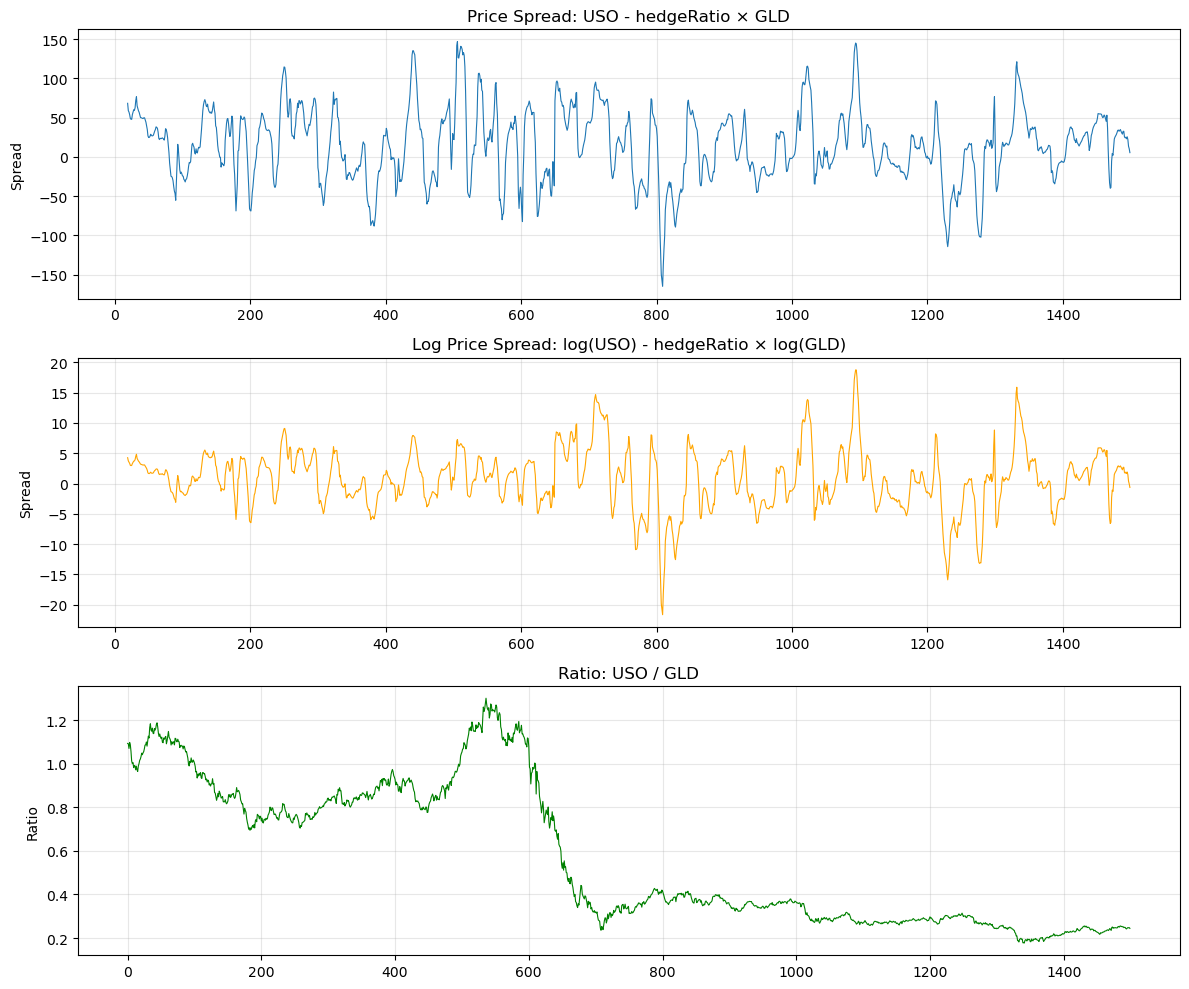

In [4]:
# 차트 생성
if df_gld_uso is not None:
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))

    axes[0].plot(spread_price.values, linewidth=0.8)
    axes[0].set_title('Price Spread: USO - hedgeRatio × GLD', fontsize=12)
    axes[0].set_ylabel('Spread')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(spread_log.values, linewidth=0.8, color='orange')
    axes[1].set_title('Log Price Spread: log(USO) - hedgeRatio × log(GLD)', fontsize=12)
    axes[1].set_ylabel('Spread')
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(ratio.values, linewidth=0.8, color='green')
    axes[2].set_title('Ratio: USO / GLD', fontsize=12)
    axes[2].set_ylabel('Ratio')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


---

## 4. 볼린저 밴드 전략

### 📈 전략 원리

볼린저 밴드는 **이산적 진입/청산**을 사용하는 실용적인 평균 회귀 전략입니다.

```python
# Z-Score 계산
z_score = (spread - moving_avg) / moving_std

# 진입 조건
long_entry = z_score < -entry_zscore   # 저평가 → 매수
short_entry = z_score > entry_zscore   # 고평가 → 매도

# 청산 조건
long_exit = z_score >= -exit_zscore    # 평균 회복
short_exit = z_score <= exit_zscore
```

### 4.1 장점

- **자본 관리 용이**: 0 또는 1 단위만 투자
- **파라미터 최적화 가능**: `entry_zscore`, `exit_zscore`, `lookback`
- **선형 전략 대비 개선된 성과**


In [5]:
# 볼린저 밴드 전략 분석
print("=" * 60)
print("📊 2. 볼린저 밴드 전략 분석")
print("=" * 60)

results['bollinger'] = {}

if df_gld_uso is None:
    print("  ✗ GLD/USO 데이터 없음 - 분석 건너뜀")
else:
    df = df_gld_uso.copy()
    lookback = 20

    # 동적 헤지 비율 계산
    print("  ⏳ RollingOLS 계산 중...")
    endog = df['USO']
    exog = sm.add_constant(df['GLD'])
    rols = RollingOLS(endog, exog, window=lookback)
    rres = rols.fit()

    hedge_ratio = rres.params['GLD']

    # 스프레드 계산
    yport = df['USO'] - hedge_ratio * df['GLD']

    # Z-Score 계산
    ma = yport.rolling(lookback).mean()
    mstd = yport.rolling(lookback).std()
    zScore = (yport - ma) / mstd

    # 볼린저 밴드 진입/청산
    entry_zscore = 1
    exit_zscore = 0

    longs_entry = zScore < -entry_zscore
    longs_exit = zScore >= -exit_zscore
    shorts_entry = zScore > entry_zscore
    shorts_exit = zScore <= exit_zscore

    # 포지션 계산
    num_units_long = np.zeros(len(df))
    num_units_long[:] = np.nan
    num_units_long[0] = 0
    num_units_long[longs_entry] = 1
    num_units_long[longs_exit] = 0
    num_units_long = pd.Series(num_units_long).ffill()

    num_units_short = np.zeros(len(df))
    num_units_short[:] = np.nan
    num_units_short[0] = 0
    num_units_short[shorts_entry] = -1
    num_units_short[shorts_exit] = 0
    num_units_short = pd.Series(num_units_short).ffill()

    num_units = num_units_long + num_units_short

    # 포지션 및 P&L
    positions = pd.DataFrame({
        'GLD': -num_units.values * hedge_ratio * df['GLD'].values,
        'USO': num_units.values * df['USO'].values
    })

    pnl = (positions.shift() * df.pct_change().values).sum(axis=1)
    ret = pnl / positions.shift().abs().sum(axis=1)
    ret_clean = pd.Series(ret).replace([np.inf, -np.inf], np.nan).dropna()

    apr = np.prod(1 + ret_clean) ** (252 / len(ret_clean)) - 1
    sharpe = np.sqrt(252) * ret_clean.mean() / ret_clean.std()

    # 최대 낙폭 계산
    cumret = np.cumprod(1 + ret_clean)
    highwatermark = pd.Series(cumret).cummax()
    drawdown = (cumret - highwatermark) / highwatermark
    max_dd = drawdown.min()

    results['bollinger']['gld_uso'] = {
        'entry_zscore': entry_zscore,
        'exit_zscore': exit_zscore,
        'lookback': lookback,
        'apr': apr,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'num_trades': int((num_units.diff().abs() > 0).sum()),
        'num_days': len(ret_clean)
    }

    print(f"\n### GLD-USO 볼린저 밴드 전략")
    print("-" * 40)
    print(f"  진입 Z-Score: ±{entry_zscore}")
    print(f"  청산 Z-Score: {exit_zscore}")
    print(f"  Lookback: {lookback}일")
    print(f"  연간 수익률 (APR): {apr*100:.2f}%")
    print(f"  샤프 비율: {sharpe:.4f}")
    print(f"  최대 낙폭 (MDD): {max_dd*100:.2f}%")

    if sharpe > 0.5:
        print(f"  → ✅ 볼린저 밴드가 선형 전략 대비 개선")
    else:
        print(f"  → ⚠️ 전략 개선 필요")


📊 2. 볼린저 밴드 전략 분석
  ⏳ RollingOLS 계산 중...

### GLD-USO 볼린저 밴드 전략
----------------------------------------
  진입 Z-Score: ±1
  청산 Z-Score: 0
  Lookback: 20일
  연간 수익률 (APR): 23.86%
  샤프 비율: 1.1067
  최대 낙폭 (MDD): -21.83%
  → ✅ 볼린저 밴드가 선형 전략 대비 개선


### 4.2 GLD-USO 볼린저 밴드 전략 결과

**파라미터:**

- Entry Z-Score: ±1
- Exit Z-Score: 0
- Lookback: 20일

**성과 지표:**

| 지표 | 값 | 평가 |
|------|------|------|
| 연간 수익률 (APR) | 23.86% | ✅ 우수 |
| **샤프 비율** | **1.1067** | ✅ 우수 |
| 최대 낙폭 (MDD) | -21.83% | ⚠️ 주의 |

### 4.3 볼린저 밴드 전략 차트

> 📊 **차트 해석**:
> - 상단: 스프레드와 볼린저 밴드 (빨강=상단 밴드, 초록=하단 밴드)
> - 중단: Z-Score와 진입/청산 임계값
> - 하단: 누적 수익률


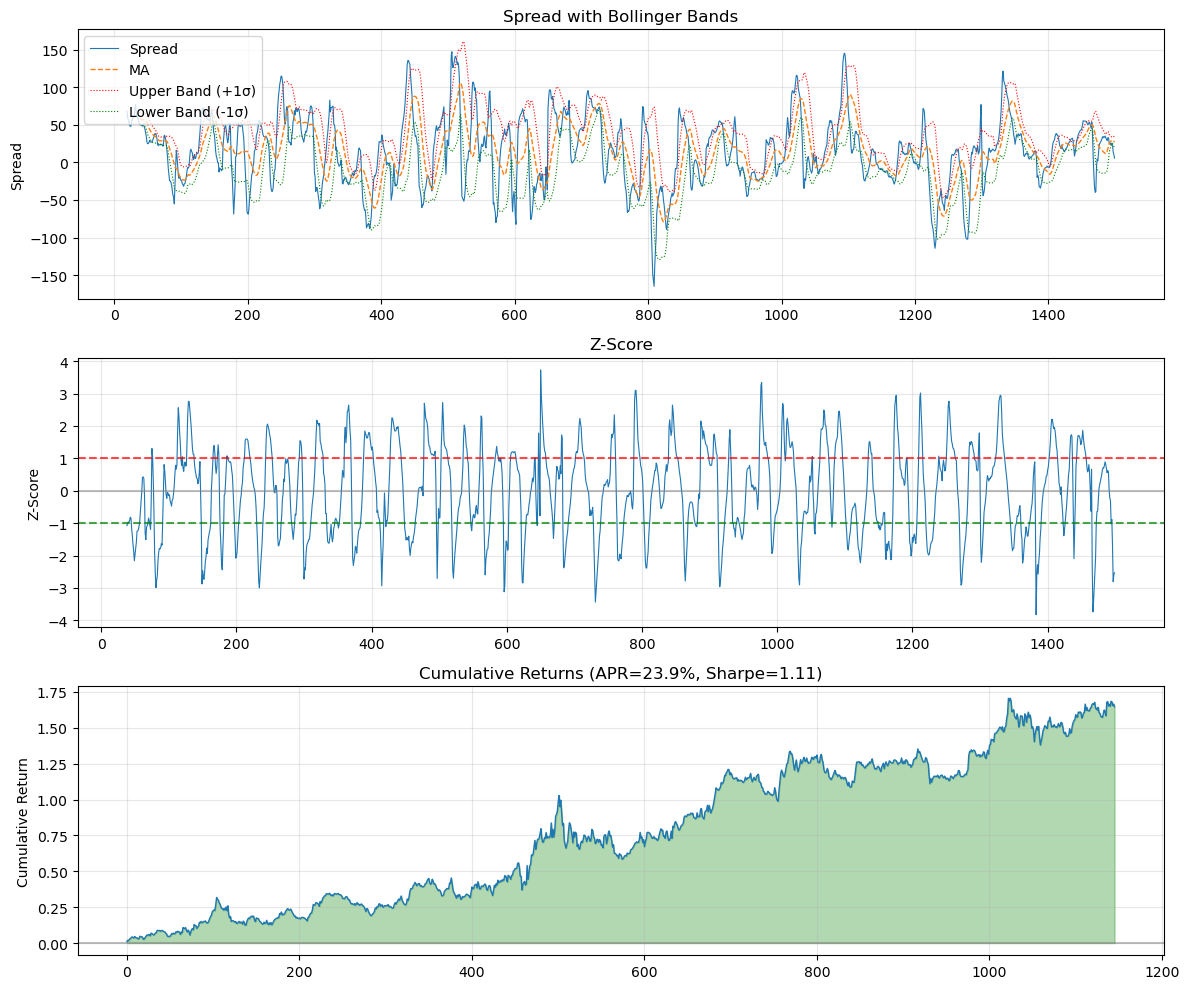

In [6]:
# 차트 생성
if df_gld_uso is not None:
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))

    # 스프레드와 볼린저 밴드
    axes[0].plot(yport.values, linewidth=0.8, label='Spread')
    axes[0].plot(ma.values, linewidth=1, linestyle='--', label='MA')
    axes[0].plot((ma + entry_zscore * mstd).values, linewidth=0.8, linestyle=':', color='red', label=f'Upper Band (+{entry_zscore}σ)')
    axes[0].plot((ma - entry_zscore * mstd).values, linewidth=0.8, linestyle=':', color='green', label=f'Lower Band (-{entry_zscore}σ)')
    axes[0].set_title('Spread with Bollinger Bands', fontsize=12)
    axes[0].set_ylabel('Spread')
    axes[0].legend(loc='upper left')
    axes[0].grid(True, alpha=0.3)

    # Z-Score
    axes[1].plot(zScore.values, linewidth=0.8)
    axes[1].axhline(y=entry_zscore, color='red', linestyle='--', alpha=0.7)
    axes[1].axhline(y=-entry_zscore, color='green', linestyle='--', alpha=0.7)
    axes[1].axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    axes[1].set_title('Z-Score', fontsize=12)
    axes[1].set_ylabel('Z-Score')
    axes[1].grid(True, alpha=0.3)

    # 누적 수익률
    cumret_plot = np.cumprod(1 + ret_clean) - 1
    axes[2].plot(cumret_plot.values, linewidth=1)
    axes[2].axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    axes[2].fill_between(range(len(cumret_plot)), 0, cumret_plot.values,
                       where=cumret_plot.values >= 0, alpha=0.3, color='green')
    axes[2].fill_between(range(len(cumret_plot)), 0, cumret_plot.values,
                       where=cumret_plot.values < 0, alpha=0.3, color='red')
    axes[2].set_title(f'Cumulative Returns (APR={apr*100:.1f}%, Sharpe={sharpe:.2f})', fontsize=12)
    axes[2].set_ylabel('Cumulative Return')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


---

## 5. 칼만 필터 전략

### 🔧 칼만 필터란?

칼만 필터는 **숨겨진 변수의 최적 추정**을 위한 선형 알고리즘입니다.

**핵심 방정식:**

$$y(t) = x(t) \beta(t) + \epsilon(t) \quad \text{(측정 방정식)}$$

$$\beta(t) = \beta(t-1) + \omega(t-1) \quad \text{(상태 전이)}$$

$$\hat{\beta}(t|t) = \hat{\beta}(t|t-1) + K(t) \cdot e(t) \quad \text{(상태 업데이트)}$$

### 5.1 칼만 필터의 장점

| 장점 | 설명 |
|------|------|
| **동적 헤지 비율** | 시간에 따라 변하는 헤지 비율 자동 추정 |
| **스프레드 평균** | 절편(β₀)이 스프레드의 이동 평균 역할 |
| **예측 오차 분산** | √Q(t)가 볼린저 밴드의 표준편차 역할 |
| **데이터 가중** | 최신 데이터에 더 많은 가중치, 임의 절단점 없음 |


In [7]:
# 칼만 필터 기반 동적 헤지 비율 분석
print("=" * 60)
print("🔧 3. 칼만 필터 전략 분석")
print("=" * 60)

results['kalman'] = {}

if df_ewa_ewc is None:
    print("  ✗ EWA/EWC 데이터 없음 - 분석 건너뜀")
else:
    df = df_ewa_ewc.copy()

    # 칼만 필터 구현
    x = df['EWA'].values
    y = df['EWC'].values

    # x에 절편 항 추가 [EWA, 1]
    x_aug = np.column_stack([x, np.ones(len(x))])

    # 칼만 필터 파라미터
    delta = 0.0001  # 상태 변화율
    Ve = 0.001      # 측정 오차 분산

    # 초기화
    n = len(y)
    yhat = np.full(n, np.nan)  # 예측값
    e = np.full(n, np.nan)     # 예측 오차
    Q = np.full(n, np.nan)     # 예측 오차 분산

    R = np.zeros((2, 2))       # 상태 공분산
    P = R.copy()
    beta = np.full((2, n), np.nan)  # [기울기, 절편]

    Vw = delta / (1 - delta) * np.eye(2)  # 상태 전이 노이즈 공분산

    # 초기 beta
    beta[:, 0] = 0

    # 칼만 필터 반복
    for t in range(n):
        if t > 0:
            beta[:, t] = beta[:, t-1]  # 상태 예측
            R = P + Vw                  # 상태 공분산 예측

        yhat[t] = np.dot(x_aug[t, :], beta[:, t])  # 측정 예측
        Q[t] = np.dot(np.dot(x_aug[t, :], R), x_aug[t, :].T) + Ve  # 측정 분산 예측

        e[t] = y[t] - yhat[t]  # 예측 오차

        K = np.dot(R, x_aug[t, :].T) / Q[t]  # 칼만 이득
        beta[:, t] = beta[:, t] + K * e[t]  # 상태 업데이트
        P = R - np.outer(K, x_aug[t, :]) @ R  # 상태 공분산 업데이트

    # 거래 신호
    sqrt_Q = np.sqrt(Q)
    longs_entry = e < -sqrt_Q
    longs_exit = e > 0
    shorts_entry = e > sqrt_Q
    shorts_exit = e < 0

    # 포지션 계산
    num_units_long = np.zeros(n)
    num_units_long[:] = np.nan
    num_units_long[0] = 0
    num_units_long[longs_entry] = 1
    num_units_long[longs_exit] = 0
    num_units_long = pd.Series(num_units_long).ffill()

    num_units_short = np.zeros(n)
    num_units_short[:] = np.nan
    num_units_short[0] = 0
    num_units_short[shorts_entry] = -1
    num_units_short[shorts_exit] = 0
    num_units_short = pd.Series(num_units_short).ffill()

    num_units = num_units_long + num_units_short

    # 헤지 비율 (기울기)
    hedge_ratio = beta[0, :]

    # 포지션 및 P&L
    positions = pd.DataFrame({
        'EWA': -num_units.values * hedge_ratio * df['EWA'].values,
        'EWC': num_units.values * df['EWC'].values
    })

    pnl = (positions.shift() * df.pct_change().values).sum(axis=1)
    ret = pnl / positions.shift().abs().sum(axis=1)
    ret_clean = pd.Series(ret).replace([np.inf, -np.inf], np.nan).dropna()

    apr = np.prod(1 + ret_clean) ** (252 / len(ret_clean)) - 1
    sharpe = np.sqrt(252) * ret_clean.mean() / ret_clean.std()

    # 최대 낙폭
    cumret = np.cumprod(1 + ret_clean)
    highwatermark = pd.Series(cumret).cummax()
    drawdown = (cumret - highwatermark) / highwatermark
    max_dd = drawdown.min()

    results['kalman']['ewa_ewc'] = {
        'delta': delta,
        'Ve': Ve,
        'apr': apr,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'num_days': len(ret_clean),
        'beta_slope_mean': np.nanmean(beta[0, :]),
        'beta_slope_std': np.nanstd(beta[0, :]),
        'beta_intercept_mean': np.nanmean(beta[1, :]),
        'beta_intercept_std': np.nanstd(beta[1, :])
    }

    print(f"\n### EWA-EWC 칼만 필터 전략")
    print("-" * 40)
    print(f"  δ (상태 변화율): {delta}")
    print(f"  Vε (측정 오차 분산): {Ve}")
    print(f"  평균 헤지 비율: {np.nanmean(beta[0, :]):.4f} ± {np.nanstd(beta[0, :]):.4f}")
    print(f"  연간 수익률 (APR): {apr*100:.2f}%")
    print(f"  샤프 비율: {sharpe:.4f}")
    print(f"  최대 낙폭 (MDD): {max_dd*100:.2f}%")

    if sharpe > 1.0:
        print(f"  → ✅ 칼만 필터 우수한 성과")
    else:
        print(f"  → ⚠️ 파라미터 조정 필요")


🔧 3. 칼만 필터 전략 분석

### EWA-EWC 칼만 필터 전략
----------------------------------------
  δ (상태 변화율): 0.0001
  Vε (측정 오차 분산): 0.001
  평균 헤지 비율: 1.0897 ± 0.1624
  연간 수익률 (APR): 54.55%
  샤프 비율: 3.3130
  최대 낙폭 (MDD): -8.94%
  → ✅ 칼만 필터 우수한 성과


### 5.2 EWA-EWC 칼만 필터 전략 결과

**파라미터:**

- δ (상태 변화율): 0.0001
- Vε (측정 오차 분산): 0.001
- 평균 헤지 비율: 1.0897 ± 0.1624

**성과 지표:**

| 지표 | 값 | 평가 |
|------|------|------|
| 연간 수익률 (APR) | 54.55% | ✅ 우수 |
| **샤프 비율** | **3.3130** | ✅ 우수 |
| 최대 낙폭 (MDD) | -8.94% | ✅ 양호 |

### 5.3 칼만 필터 전략 차트

> 📊 **차트 해석**:
> - 1행: 칼만 필터 추정 기울기 (헤지 비율) - 1 주위에서 진동
> - 2행: 칼만 필터 추정 절편 - 시간에 따라 변화
> - 3행: 예측 오차 e(t)와 표준편차 √Q(t)
> - 4행: 누적 수익률


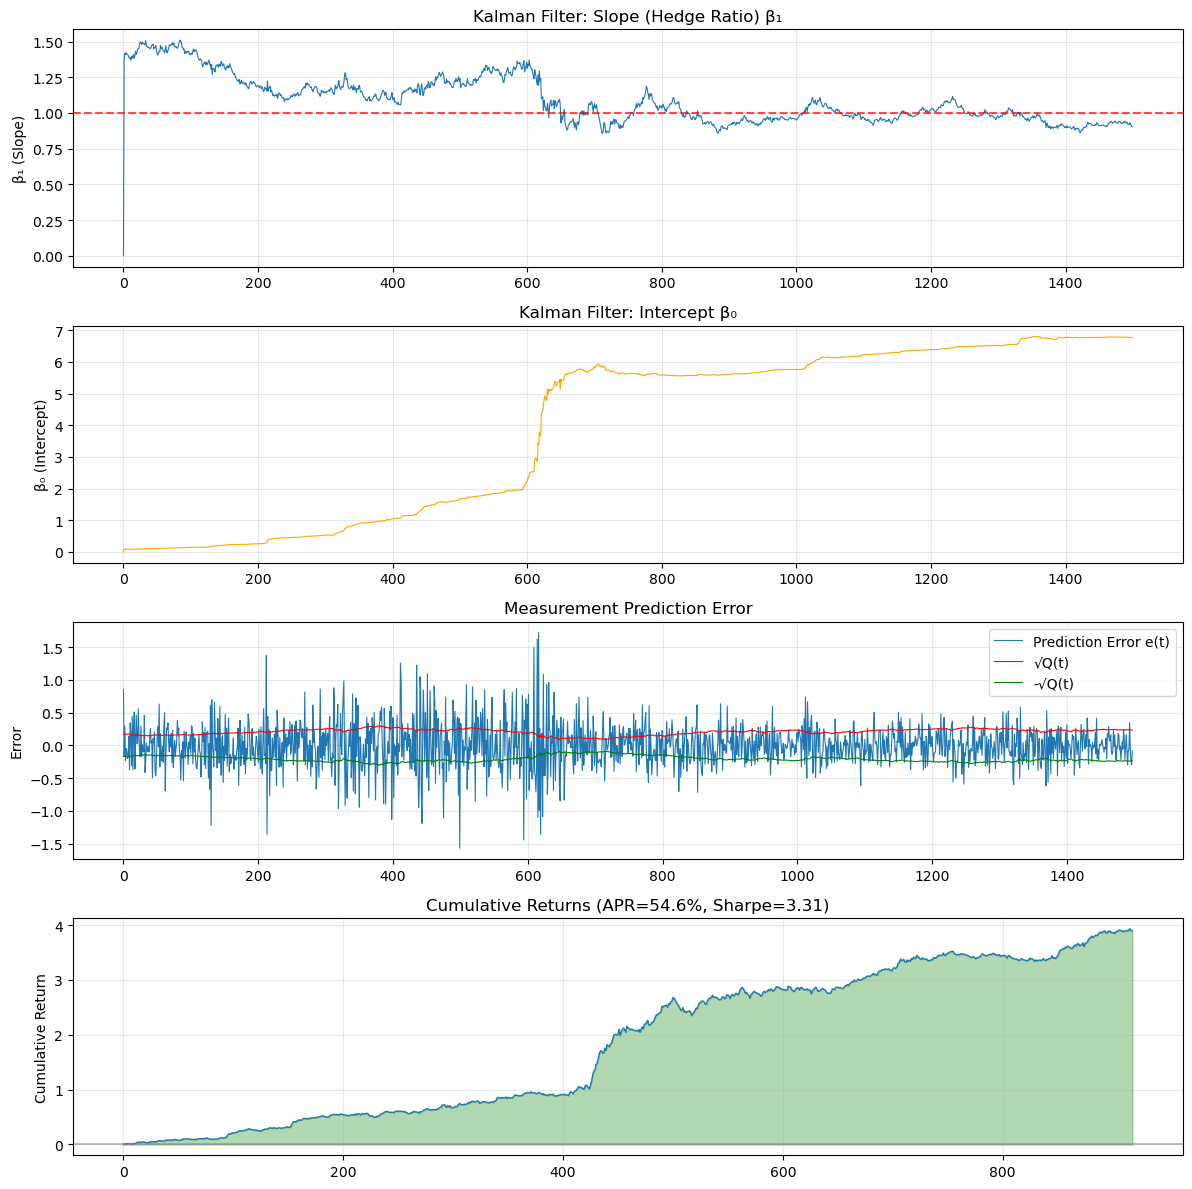

In [8]:
# 차트 생성
if df_ewa_ewc is not None:
    fig, axes = plt.subplots(4, 1, figsize=(12, 12))

    # 헤지 비율 (기울기)
    axes[0].plot(beta[0, :], linewidth=0.8)
    axes[0].axhline(y=1, color='red', linestyle='--', alpha=0.7)
    axes[0].set_title('Kalman Filter: Slope (Hedge Ratio) β₁', fontsize=12)
    axes[0].set_ylabel('β₁ (Slope)')
    axes[0].grid(True, alpha=0.3)

    # 절편
    axes[1].plot(beta[1, :], linewidth=0.8, color='orange')
    axes[1].set_title('Kalman Filter: Intercept β₀', fontsize=12)
    axes[1].set_ylabel('β₀ (Intercept)')
    axes[1].grid(True, alpha=0.3)

    # 예측 오차와 표준편차
    axes[2].plot(e[2:], linewidth=0.8, label='Prediction Error e(t)')
    axes[2].plot(sqrt_Q[2:], linewidth=0.8, color='red', label='√Q(t)')
    axes[2].plot(-sqrt_Q[2:], linewidth=0.8, color='green', label='-√Q(t)')
    axes[2].set_title('Measurement Prediction Error', fontsize=12)
    axes[2].set_ylabel('Error')
    axes[2].legend(loc='upper right')
    axes[2].grid(True, alpha=0.3)

    # 누적 수익률
    cumret_plot = np.cumprod(1 + ret_clean) - 1
    axes[3].plot(cumret_plot.values, linewidth=1)
    axes[3].axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    axes[3].fill_between(range(len(cumret_plot)), 0, cumret_plot.values,
                       where=cumret_plot.values >= 0, alpha=0.3, color='green')
    axes[3].fill_between(range(len(cumret_plot)), 0, cumret_plot.values,
                       where=cumret_plot.values < 0, alpha=0.3, color='red')
    axes[3].set_title(f'Cumulative Returns (APR={apr*100:.1f}%, Sharpe={sharpe:.2f})', fontsize=12)
    axes[3].set_ylabel('Cumulative Return')
    axes[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


---

## 6. 전략 비교 및 결론

### ✅ 핵심 발견

| 전략 | 데이터 | APR | 샤프 | 장점 |
|------|--------|-----|------|------|
| 선형 (가격 스프레드) | GLD-USO | 11.2% | 0.60 | 단순함 |
| 볼린저 밴드 | GLD-USO | 23.9% | 1.11 | 자본 관리 용이 |
| 칼만 필터 | EWA-EWC | 54.6% | 3.31 | 동적 헤지 비율 |

### 💡 트레이딩 권고사항

1. **스프레드 유형 선택**:
   - 공적분 페어: 가격 스프레드 또는 로그 가격 스프레드 사용
   - 비공적분 페어: 동적 헤지 비율 필수, 비율은 피하기

2. **볼린저 밴드 전략**:
   - 선형 전략의 실용적 대안
   - Entry/Exit Z-Score는 훈련 데이터로 최적화

3. **칼만 필터 전략**:
   - 공적분 페어에서 가장 우수한 성과
   - δ 파라미터로 헤지 비율 변화 속도 조절

### ⚠️ 주의사항

- **데이터 오류**: 평균 회귀 전략은 이상치에 특히 민감 (잘못된 수익 부풀리기 위험)
- **스케일 인**: 이론적으로 최적이 아닐 수 있으나, 실제로는 변동성 변화에 유용
- **거래 비용**: 본 백테스트에 미포함
- **Look-ahead bias**: 전체 데이터로 파라미터 계산 후 동일 데이터로 테스트

---
